In [ ]:
# default_exp dualrnn
# default_cls_lvl 3

In [ ]:
#hide
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


# Dual RNN Models
> Pytorch Models for Sequential Data

In [ ]:
#export
from seqdata.core import *
from seqdata.models.core import *
from seqdata.learner import *
from seqdata.dataloaders import *
from fastai.basics import *
from fastai.callback.progress import *
from fastai.callback.schedule import *

In [ ]:
init_sz = 100
seq = DataBlock(blocks=(SequenceBlock.from_hdf(['current','voltage'],TensorSequencesInput,clm_shift=[0,-1]),
                        SequenceBlock.from_hdf(['voltage'],TensorSequencesOutput,clm_shift=[-1])),
                 get_items=CreateDict([DfHDFCreateWindows(win_sz=20000+1,stp_sz=2000,clm='current')]),
                 splitter=ApplyToDict(ParentSplitter()))
dl_kwargs=[{'sub_seq_len':1000}]*2
db = seq.dataloaders(get_hdf_files('test_data/'),bs=32,dl_type=TbpttDl,dl_kwargs=dl_kwargs)

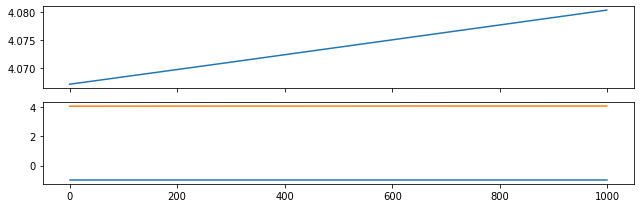

In [ ]:
db.show_batch(max_n=1)

## ProDiag

In [ ]:
#export
class ProDiagTrainer(Callback):
    "`Callback` that regroups lr adjustment to seq_len, AR and TAR."
    def __init__(self, alpha=1e6,beta=1,p_own_state=0):
        store_attr('alpha,beta,p_own_state')
        self.main_init_prop = None

    def _has_main_init(self):
        return hasattr(self.learn.model,'main_init_prop')

    def begin_fit(self):
        if self._has_main_init():
            self.main_init_prop=self.learn.model.main_init_prop

    def begin_batch(self):
        if not self.training or self.p_own_state == 0: return
        main_init_prop = random.random()< self.p_own_state
        self.learn.model.main_init_prop = main_init_prop

    def after_pred(self):
        p,self.pred_diag,self.est_hidden,self.pred_hidden=self.pred
        self.learn.pred = p

    def after_loss(self):
        if not self.training: return
        self.learn.loss = self.learn.loss+self.beta*self.learn.loss_func(self.pred_diag,*self.yb)

        hidden_loss = ((self.est_hidden-self.pred_hidden)/
                       (self.est_hidden.norm()+self.pred_hidden.norm())).pow(2).mean()
        self.learn.loss = self.learn.loss+self.alpha * hidden_loss

    def begin_validate(self):
        '''Set Dual RNN to reuse the prediction state after each mini batch on validation'''
        if self._has_main_init():
            self.learn.model.main_init_prop = True

    def after_validate(self):
        '''Reset Dual RNN to training state propagation behaviour'''
        if self._has_main_init():
            self.learn.model.main_init_prop=self.main_init_prop


    def after_fit(self):
        reset_model_state(self.learn.model)

In [ ]:
#export
class DualRNN(nn.Module):
    
    @delegates(RNN, keep=True)
    def __init__(self,main_input_size,co_input_size,output_size,init_sz=100,hidden_size=100,
                 rnn_layer=1,linear_layer = 1,main_init_est = True,main_init_prop = True,**kwargs):
        super().__init__()
        store_attr('main_input_size,co_input_size,main_init_est,main_init_prop,init_sz')
        
        rnn_kwargs = dict(hidden_size=hidden_size,num_layers=rnn_layer,stateful=True,ret_full_hidden=True)
        rnn_kwargs = dict(rnn_kwargs, **kwargs)
        
        self.co_rnn = RNN(co_input_size,**rnn_kwargs) 
        self.main_rnn = RNN(main_input_size,**rnn_kwargs) 

#         self.co_estimator = SeqLinear(hidden_size,output_size,hidden_layer=linear_layer)
        self.main_estimator = SeqLinear(hidden_size,output_size,hidden_layer=linear_layer)

    def forward(self, x,init_state = None):
        bs = x.shape[0]
        if init_state is None:
            init_state = self.main_rnn._get_hidden(bs) if self.main_init_prop else self.co_rnn._get_hidden(bs)
        
        
        x_co = x[...,:self.co_input_size]
        x_main = x[...,:self.main_input_size]
            
        #RNN Layer 
        if init_state is None:
#             import pdb; pdb.set_trace()
            if self.main_init_est:
                out_init,h_init = self.main_rnn(x_main[:,:self.init_sz])
                out_main,_ = self.main_rnn(x_main[:,self.init_sz:],h_init)
                out_co,_ = self.co_rnn(x_co[:,self.init_sz:],h_init)  
                out_main=torch.cat([out_init,out_main],2) 
                out_co=torch.cat([out_init,out_co],2) 
            else:
                out_init,h_init = self.co_rnn(x_co[:,:self.init_sz])
                out_co,_ = self.co_rnn(x_co[:,self.init_sz:],h_init)
                out_main,_ = self.main_rnn(x_main[:,self.init_sz:],h_init)  
                out_main=torch.cat([out_init,out_main],2) 
                out_co=torch.cat([out_init,out_co],2) 
        else:  
            out_co,_ = self.co_rnn(x_co,init_state)         
            out_main,_ = self.main_rnn(x_main,init_state)
            
            
#         import pdb; pdb.set_trace()
            
        #Shared Linear Layer
        est_co = self.main_estimator(out_co[-1])
        est_main = self.main_estimator(out_main[-1])

#         import pdb; pdb.set_trace()   
        return est_main,est_co, out_co,out_main

In [ ]:
model = DualRNN(1,2,1,init_sz=500,linear_layer=2,rnn_layer=1,hidden_size=100,main_init_est=False,main_init_prop=False)
lrn = Learner(db,model,loss_func=nn.MSELoss(),cbs=ProDiagTrainer(),opt_func=ranger)
lrn.add_cb(TbpttResetCB())

In [ ]:
lrn.fit(1)

epoch,train_loss,valid_loss,time
0,6.333662,0.172134,00:18


## Dual CRNN

In [ ]:
#export
class DualCRNN(nn.Module):
    
    @delegates(RNN, keep=True)
    def __init__(self,main_input_size,co_input_size,output_size,init_sz=100,tcn_hidden_size=100,tcn_layer=8,rnn_hidden_size=100,
                 rnn_layer=1,linear_layer = 1,main_init_est = True,main_init_prop = True,**kwargs):
        super().__init__()
        store_attr('main_input_size,co_input_size,main_init_est,main_init_prop,init_sz')
        
        rnn_kwargs = dict(hidden_size=rnn_hidden_size,num_layers=rnn_layer,stateful=True,ret_full_hidden=True)
        rnn_kwargs = dict(rnn_kwargs, **kwargs)
        
        self.co_tcn = TCN(co_input_size,rnn_hidden_size,tcn_layer,tcn_hidden_size,stateful=True) 
        self.main_tcn = TCN(main_input_size,rnn_hidden_size,tcn_layer,tcn_hidden_size,stateful=True)
        
        self.co_rnn = RNN(rnn_hidden_size,**rnn_kwargs) 
        self.main_rnn = RNN(rnn_hidden_size,**rnn_kwargs) 

#         self.co_estimator = SeqLinear(rnn_hidden_size,output_size,hidden_layer=linear_layer)
        self.main_estimator = SeqLinear(rnn_hidden_size,output_size,hidden_layer=linear_layer)

    def forward(self, x,init_state = None):
        bs = x.shape[0]
        if init_state is None:
            init_state = self.main_rnn._get_hidden(bs) if self.main_init_prop else self.co_rnn._get_hidden(bs)
        
        
        x_co = x[...,:self.co_input_size]
        x_main = x[...,:self.main_input_size]
        
        #TCN Layer
        x_co = self.co_tcn(x_co)
        x_main = self.main_tcn(x_main)
        
            
        #RNN Layer 
        if init_state is None:
#             import pdb; pdb.set_trace()
            if self.main_init_est:
                out_init,h_init = self.main_rnn(x_main[:,:self.init_sz])
                out_main,_ = self.main_rnn(x_main[:,self.init_sz:],h_init)
                out_co,_ = self.co_rnn(x_co[:,self.init_sz:],h_init)  
                out_main=torch.cat([out_init,out_main],2) 
                out_co=torch.cat([out_init,out_co],2) 
            else:
                out_init,h_init = self.co_rnn(x_co[:,:self.init_sz])
                out_co,_ = self.co_rnn(x_co[:,self.init_sz:],h_init)
                out_main,_ = self.main_rnn(x_main[:,self.init_sz:],h_init)  
                out_main=torch.cat([out_init,out_main],2) 
                out_co=torch.cat([out_init,out_co],2) 
        else:  
            out_co,_ = self.co_rnn(x_co,init_state)         
            out_main,_ = self.main_rnn(x_main,init_state)
            
            
#         import pdb; pdb.set_trace()
            
        #Shared Linear Layer
        est_co = self.main_estimator(out_co[-1])
        est_main = self.main_estimator(out_main[-1])

#         import pdb; pdb.set_trace()   
        return est_main,est_co, out_co,out_main

    def get_main_crnn(self):
        crnn_model = CRNN(1,1)
        crnn_model.cnn = self.main_tcn
        
        simple_rnn_model = SimpleRNN(1,1)
        simple_rnn_model.rnn = self.main_rnn
        simple_rnn_model.final = self.main_estimator
        crnn_model.rnn = simple_rnn_model
        return crnn_model
    
    
    def get_co_crnn(self):
        crnn_model = CRNN(1,1)
        crnn_model.cnn = self.co_tcn
        
        simple_rnn_model = SimpleRNN(1,1)
        simple_rnn_model.rnn = self.co_rnn
        simple_rnn_model.final = self.main_estimator
        crnn_model.rnn = simple_rnn_model
        return crnn_model

In [ ]:
model = DualCRNN(1,2,1,init_sz=500,main_init_est=False,main_init_prop=False)
lrn = Learner(db,model,loss_func=nn.MSELoss(),cbs=ProDiagTrainer(),opt_func=ranger)
lrn.add_cb(TbpttResetCB())

In [ ]:
model.get_main_crnn()

CRNN(
  (cnn): TCN(
    (conv_layers): Sequential(
      (0): TCN_Block(
        (layers): Sequential(
          (0): CausalConv1d(1, 100, kernel_size=(2,), stride=(1,), padding=(1,))
          (1): Mish()
        )
        (residual): Conv1d(1, 100, kernel_size=(1,), stride=(1,))
      )
      (1): TCN_Block(
        (layers): Sequential(
          (0): CausalConv1d(100, 100, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
          (1): Mish()
        )
      )
      (2): TCN_Block(
        (layers): Sequential(
          (0): CausalConv1d(100, 100, kernel_size=(2,), stride=(1,), padding=(4,), dilation=(4,))
          (1): Mish()
        )
      )
      (3): TCN_Block(
        (layers): Sequential(
          (0): CausalConv1d(100, 100, kernel_size=(2,), stride=(1,), padding=(8,), dilation=(8,))
          (1): Mish()
        )
      )
      (4): TCN_Block(
        (layers): Sequential(
          (0): CausalConv1d(100, 100, kernel_size=(2,), stride=(1,), padding=(16,), dila

In [ ]:
# btch = 6
# plt.figure()
# plt.plot(lrn.y.cpu()[btch,:,0])
# plt.plot(lrn.pred.cpu()[btch,:,0])
# plt.figure()
# plt.plot(lrn.y.cpu()[btch,:,0])
# plt.plot(lrn.pred.cpu()[btch,:,1])

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_models.ipynb.
Converted 01a_IndRNN.ipynb.
Converted 02_learner.ipynb.
Converted 03_dataloaders.ipynb.
Converted 11_dualrnn.ipynb.
Converted 12_TensorQuaternions.ipynb.
Converted 13_HPOpt.ipynb.
Converted index.ipynb.
